## Домашняя работа по современным сверточным нейросетям
**Kaggle: [competition](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition), [invite link](https://www.kaggle.com/t/d4064bcb01564f05bc5c0da9d141cd7c)**

**Kaggle deadline: 13.02.2022 23:59:00 +0000 GMT**

### Описание

В этой домашней работе нужно написать сверточную нейронную сеть для классификации изображений.

Вам предоставлен измененный датасет The Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)). В нём содержится 50 тысяч (train) + 25 тысяч (test) RGB изображений размера 32х32 c цифрами, вырезанными из реальных фотографий номеров домов.

Задача: используя свёрточные нейронные сети, добиться максимальной точности классификации.

В данном домашнем задании нет никаких ограничений по архитектуре модели, но реализовывать в PyTorch её надо самим и обучить с нуля только на данном датасете, без внешних данных.

### Данные

В данном ноутбуке уже есть код для PyTorch, отвечающий за загрузку данных. Ниже приведено краткое описание формата хранения данных.

Каждый из файлов — сериализованный с помощью `pickle` c 4-ой версией протокола (которая стала версией по умолчанию в Python 3.8 и старше) python-словарик.

Список файлов:

- `meta` — метаданные датасета (например, названия классов)
- `data_train` — данные для обучения, 50К объектов
- `data_test` — данные для теста, 25К объектов, без правильных классов

Словарики с данными имеют следующие поля:

- `section` — имя части данных (train/test)
- `labels` — ground-truth классы, список из `N` чисел от 0 до 9
- `images` — numpy-массив размером `(N, 32, 32, 3)` с изображениями

### Оценка

Качество решения будет оцениваться по метрике accuracy (точность). Accuracy – это количество правильно классифицированных картинок к общему числу картинок в тестовом наборе. Публичный лидерборд рассчитывается по 30% тестовых данных, поэтому старайтесь не переобучаться под него.

```
accuracy = (correct classified) / (total # of examples)
```

В качестве решения вы должны прислать файл формата:

```
Id,Category
0, 3
1, 2
2, 9
3, 1
...
```

где:

- `Id` — порядковый номер объекта в тестовом датасете
- `Category` — предсказанный класс объекта

В данном ноутбуке уже есть код, подготавливающий файл решения.

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных/важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

## Решение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [2]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
import torch.nn.functional as F
import math
import tqdm
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.pytorch.transforms import ToTensorV2
from collections import namedtuple

Данные лежат в секции [Data](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition/data) kaggle-соревнования. <br>
Нужно скачать архив с данными и распаковать его. <br>
В переменной ниже указываем путь до датасета. <br>

In [4]:
dataset_root = "/kaggle/input/siriusds/"

Код для загрузки измененного датасета SVHN. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `is_train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [5]:
class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

Загружаем часть датасета для обучения.

In [6]:
class CustomCutout(DualTransform):
    """
    Custom Cutout augmentation with handling of bounding boxes 
    Note: (only supports square cutout regions)
    
    Author: Kaushal28
    Reference: https://arxiv.org/pdf/1708.04552.pdf
    """
    
    def __init__(
        self,
        fill_value=0,
        bbox_removal_threshold=0.50,
        min_cutout_size=192,
        max_cutout_size=512,
        always_apply=False,
        p=0.5
    ):
        """
        Class construstor
        
        :param fill_value: Value to be filled in cutout (default is 0 or black color)
        :param bbox_removal_threshold: Bboxes having content cut by cutout path more than this threshold will be removed
        :param min_cutout_size: minimum size of cutout (192 x 192)
        :param max_cutout_size: maximum size of cutout (512 x 512)
        """
        super(CustomCutout, self).__init__(always_apply, p)  # Initialize parent class
        self.fill_value = fill_value
        self.bbox_removal_threshold = bbox_removal_threshold
        self.min_cutout_size = min_cutout_size
        self.max_cutout_size = max_cutout_size
        
    def _get_cutout_position(self, img_height, img_width, cutout_size):
        """
        Randomly generates cutout position as a named tuple
        
        :param img_height: height of the original image
        :param img_width: width of the original image
        :param cutout_size: size of the cutout patch (square)
        :returns position of cutout patch as a named tuple
        """
        position = namedtuple('Point', 'x y')
        return position(
            np.random.randint(0, img_width - cutout_size + 1),
            np.random.randint(0, img_height - cutout_size + 1)
        )
        
    def _get_cutout(self, img_height, img_width):
        """
        Creates a cutout pacth with given fill value and determines the position in the original image
        
        :param img_height: height of the original image
        :param img_width: width of the original image
        :returns (cutout patch, cutout size, cutout position)
        """
        cutout_size = np.random.randint(self.min_cutout_size, self.max_cutout_size + 1)
        cutout_position = self._get_cutout_position(img_height, img_width, cutout_size)
        return np.full((cutout_size, cutout_size, 3), self.fill_value), cutout_size, cutout_position
        
    def apply(self, image, **params):
        """
        Applies the cutout augmentation on the given image
        
        :param image: The image to be augmented
        :returns augmented image
        """
        image = image.copy()  # Don't change the original image
        self.img_height, self.img_width, _ = image.shape
        cutout_arr, cutout_size, cutout_pos = self._get_cutout(self.img_height, self.img_width)
        
        # Set to instance variables to use this later
        self.image = image
        self.cutout_pos = cutout_pos
        self.cutout_size = cutout_size
        
        image[cutout_pos.y:cutout_pos.y+cutout_size, cutout_pos.x:cutout_size+cutout_pos.x, :] = cutout_arr
        return image
    
    def apply_to_bbox(self, bbox, **params):
        """
        Removes the bounding boxes which are covered by the applied cutout
        
        :param bbox: A single bounding box coordinates in pascal_voc format
        :returns transformed bbox's coordinates
        """

        # Denormalize the bbox coordinates
        bbox = denormalize_bbox(bbox, self.img_height, self.img_width)
        x_min, y_min, x_max, y_max = tuple(map(int, bbox))

        bbox_size = (x_max - x_min) * (y_max - y_min)  # width * height
        overlapping_size = np.sum(
            (self.image[y_min:y_max, x_min:x_max, 0] == self.fill_value) &
            (self.image[y_min:y_max, x_min:x_max, 1] == self.fill_value) &
            (self.image[y_min:y_max, x_min:x_max, 2] == self.fill_value)
        )

        # Remove the bbox if it has more than some threshold of content is inside the cutout patch
        if overlapping_size / bbox_size > self.bbox_removal_threshold:
            return normalize_bbox((0, 0, 0, 0), self.img_height, self.img_width)

        return normalize_bbox(bbox, self.img_height, self.img_width)

    def get_transform_init_args_names(self):
        """
        Fetches the parameter(s) of __init__ method
        :returns: tuple of parameter(s) of __init__ method
        """
        return ('fill_value', 'bbox_removal_threshold', 'min_cutout_size', 'max_cutout_size', 'always_apply', 'p')

In [7]:
class Albumentations_mod:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [8]:
train_transform = albumentations.Compose(
    [
        CustomCutout(fill_value=0, bbox_removal_threshold=0.50, min_cutout_size=6, 
                     max_cutout_size=10, always_apply=False, p=0.5),
        albumentations.augmentations.geometric.rotate.SafeRotate (limit=[-10, 10], interpolation=1, border_mode=4, 
                                                                  value=None, mask_value=None, always_apply=False, p=0.5),
        albumentations.augmentations.transforms.ChannelShuffle(p = 0.5),
        albumentations.augmentations.transforms.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.5, 
                                                             hue=0.2, always_apply=False, p=0.5),
        albumentations.augmentations.transforms.GaussNoise (var_limit=(10.0, 50.0), mean=0, 
                                                            per_channel=True, always_apply=False, p=0.5),
        albumentations.augmentations.transforms.Normalize(),
        ToTensorV2(),
    ]
)
val_transform = albumentations.Compose(
    [
        albumentations.augmentations.transforms.Normalize(),
        ToTensorV2()
    ]
)

In [9]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=Albumentations_mod(train_transform),
)

Разбиваем случайным образом датасет на обучение и валидацию. <br>
На первой части будем обучать модель классификации. <br>
На второй части будем оценивать качество во время экспериментов. <br>

In [10]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

Инициализируем data loader-ы.

In [11]:
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Посмотрим, какой размерности батчи выдает data loader.

In [12]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.uint8


### Модель классификации

Определяем, на каком устройстве будем обучать модель.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Задаем архитектуру модели классификации. <br>
Тут большой простор для разных экспериментов. <br>

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))

        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        out = self.fc(out)
        return out

In [15]:
model = WideResNet(depth=28, num_classes=10, widen_factor=10,
                         dropRate=0.4)

Отправляем модель на выбранное устройство.

In [16]:
model = model.to(device)
print(model)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

### Обучение

Задаем функцию потерь (цель оптимизации) и оптимизатор.

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,40,55,70,85], gamma=0.2)

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

In [18]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [19]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    DL = {'epoch': val_ts, 'val_accuracy': val_acc}
    v = [dict(zip(DL,t)) for t in zip(*DL.values())]
    print(v)
    plt.show()            

In [20]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)
    return train_loss[-1]
            

In [21]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)
    print('val accuracy:',np.round(correct, 5))
    return test_loss, correct

Цикл обучения.

[{'epoch': 1, 'val_accuracy': 0.1903}, {'epoch': 2, 'val_accuracy': 0.4599}, {'epoch': 3, 'val_accuracy': 0.7301}, {'epoch': 4, 'val_accuracy': 0.7981}, {'epoch': 5, 'val_accuracy': 0.8363}, {'epoch': 6, 'val_accuracy': 0.8624}, {'epoch': 7, 'val_accuracy': 0.8534}, {'epoch': 8, 'val_accuracy': 0.8643}, {'epoch': 9, 'val_accuracy': 0.8736}, {'epoch': 10, 'val_accuracy': 0.8716}, {'epoch': 11, 'val_accuracy': 0.866}, {'epoch': 12, 'val_accuracy': 0.8863}, {'epoch': 13, 'val_accuracy': 0.8779}, {'epoch': 14, 'val_accuracy': 0.8729}, {'epoch': 15, 'val_accuracy': 0.8766}, {'epoch': 16, 'val_accuracy': 0.8745}, {'epoch': 17, 'val_accuracy': 0.8794}, {'epoch': 18, 'val_accuracy': 0.8913}, {'epoch': 19, 'val_accuracy': 0.8716}, {'epoch': 20, 'val_accuracy': 0.8878}, {'epoch': 21, 'val_accuracy': 0.865}, {'epoch': 22, 'val_accuracy': 0.8849}, {'epoch': 23, 'val_accuracy': 0.8799}, {'epoch': 24, 'val_accuracy': 0.8663}, {'epoch': 25, 'val_accuracy': 0.868}, {'epoch': 26, 'val_accuracy': 0.9337

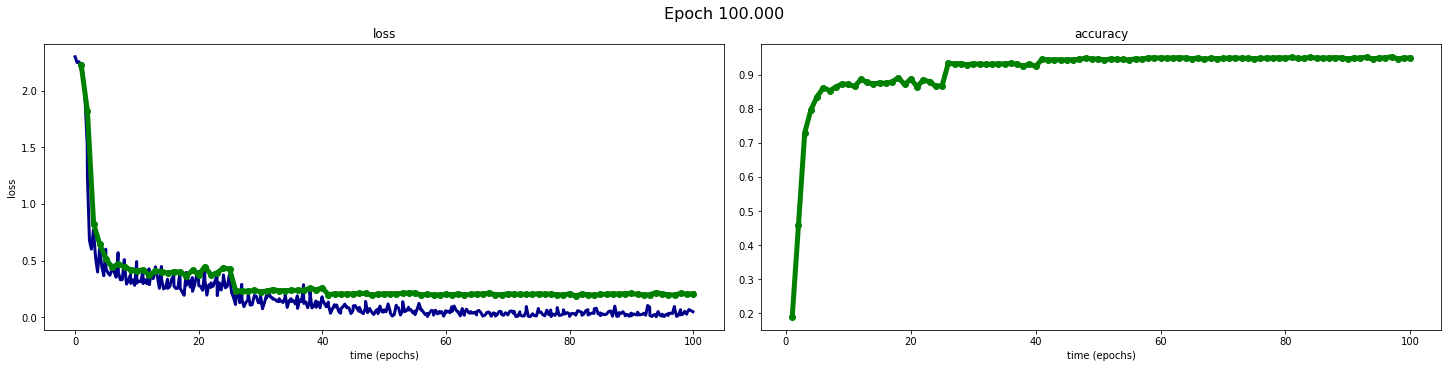

100%|██████████| 100/100 [6:30:15<00:00, 234.16s/it]

val accuracy: 0.9493


In [22]:
epochs = 100
best_acc = 0
for t in trange(epochs):
    print(f'Epoch: {t}')
    tr_loss = train(t, train_dataloader, model, loss_fn, optimizer)
    v_loss, v_acc = test(t, val_dataloader, model, loss_fn)
    scheduler.step()
    if (v_acc > best_acc):
        best_acc = v_acc
        torch.save(model.state_dict(), "weights.pth")

### Отправка решения

Загружаем часть датасета для теста.

In [23]:
test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=Albumentations_mod(val_transform),
)

In [24]:
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

Делаем предсказания итоговой моделью.

In [25]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

Формируем файл решения для отправки в kaggle.

In [26]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            
write_solution('solution.csv', predictions)